# Intro
For the purposes of this project, we are considering a stock to be an example of a *chaotic system*, in which we hope to model and predict it with the aid of discretized differential equations. 

We can query online stock APIs for 2-year daily historical price data. This is the only initial data that we need for the program. 

This means that we start with data for $p(t)$ for a specific set of points, and we want to find $p(t + 1), p(t + 2) ...$

Let a stock's particular price on a certain day be its ***position***. Then we can start our model off of basic kinematic equations from physics:

$x = x_0 + v_0t + \frac{1}{2}at^2$

$x = x_0 + \hat{v}t$

$v = v_0 + at$

But recall that:

$\frac{dx}{dt} = v, \frac{dv}{dt} = a, \frac{d^2x}{dt^2} = a$

Now, instead of $x$, let us use $p(t),$ and replace let $v = p'(t)$, $a = p''(t)$, and redefine $t = h$:

$p(t + 1) = p(t) + hp'(t) + \frac{h^2}{2}p''(t)$

PROBLEM! We can't solve for p'(t), p''(t). There is not underlying analytical function to differentiate. What can we do? 

**> Use a Discrete Method**. There are a couple different formulas, but since we are trying to predict the *next* day, we want to use a backwards difference method. This is something we struggled with and Dr. Pasteur assisted us in finding these online. Since our current approach goes up to the second derivative, we need to use (at least) 3 points for the second derivative. If possible, we should use the same number of points for calculating each derivative. So:

$p(t) = p(t)$ (trivial)

$p'(t) = \frac{3p(t) - 4p(t - 1) + p(t - 2)}{2h}$

$p''(t) = \frac{p(t) - 2p(t - 1) + p(t - 2)}{h^2}$

Now we have defined $p'(t), p''(t)$ in terms of discrete points of $p(t)$. Now we have enough to try a stock prediction... (lets convert some of this ideology to python code)

Average difference in prediction and actual value: 2.100502008032129
MSE: 11.903955622489962


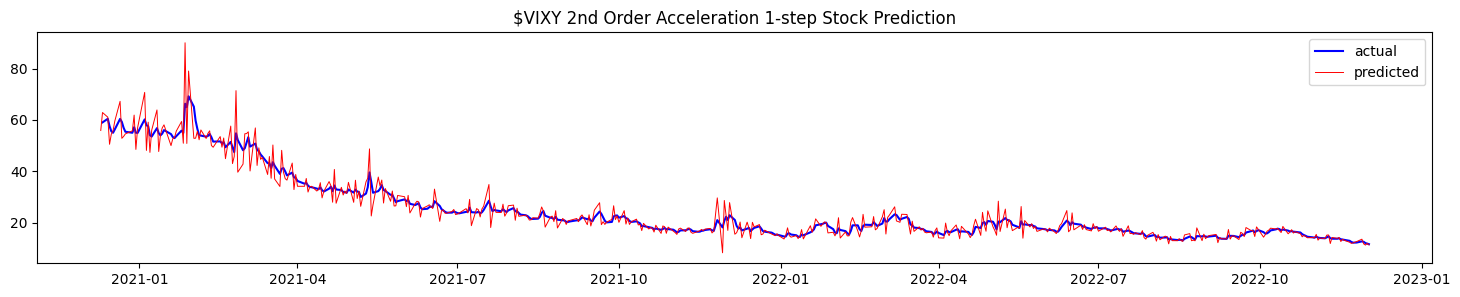

In [77]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# read in dataset
ticker="VIXY"
df = pd.read_csv(f"data/{ticker}HistoricalData.csv")

# read in discrete points for p(t)
prices = np.array(df["c"])

# sizing figure
plt.rcParams["figure.figsize"] = (18, 3)

# grab timestamps to graph on
timestamps = pd.to_datetime(df["day"])

# returns 3 x N matrix. in each row, the first entry is position, second is velocity, third is acceleration
def accel_predict(price_points):
    soln = []
    for step in range(2, prices.size):
        xi, xi_1, xi_2 = price_points[step], price_points[step-1], price_points[step-2]
        # our price at a certain point... is just the price at a certain point (😁)
        p_x = xi
        # 3 point backwards first derivative finite difference
        v_x = (3 * xi - 4 * xi_1 + xi_2) / 2
        # 4 point backward second derivative finite difference 
        a_x = (xi) - (2 * xi_1) + (xi_2)
       

        step_vec = np.array([p_x, v_x, a_x])
        soln.append(step_vec)
    return soln

def next_accel_price(inputs):
    return inputs[0] + inputs[1] + (1/2)*inputs[2]

finite_points = accel_predict(prices)

day = 2
one_step_guesses = []
for row in finite_points:
    #print("(Actual) Day",day,row[0])
    guess = np.round(next_accel_price(row), 3)
    #print("(Prediction) Day",day+1,guess)
    one_step_guesses.append(guess)
    day += 1

#print(np.array([x - y for x, y in zip(one_step_guesses, price_compare)]))
price_compare = prices[3:] # predictions start on day 2 going to day 3 :)
#print(price_compare[:10],one_step_guesses[:10])
plt.plot(timestamps[3:], price_compare, color="blue", label="actual")
plt.plot(timestamps[2:], one_step_guesses, color="red", label="predicted", linewidth=0.7)
plt.title(f"${ticker} 2nd Order Acceleration 1-step Stock Prediction")
diffs = np.array([abs(x - y) for x, y in zip(one_step_guesses, price_compare)])
print("Average difference in prediction and actual value:",np.average(diffs))
plt.legend()

mse = np.square(np.subtract(price_compare, one_step_guesses[:len(one_step_guesses)-1])).mean()
print("MSE:",mse)

# Jerk

Now, what if we wanted to add additional parameters to the equation?

When trying to model a chaotic system, we may benefit from tracking and equating the *jerk*:

Where jerk systems are the minimum requirement of a chaotic system:

$J(x''', x'',x',x) = 0$

$j = \frac{d^3x}{dt^3} = \frac{d^2v}{dt^2} = \frac{da}{dt}$

For us, this is $p'''(t)$, the third derivative of price position.

This is discretized to be:

$p'''(t) = \frac{p(t) - 3p(t-1) + 3p(t-2) - p(t-3)}{h^4}$

Additionally, now we want 4 points in our backwards discrete difference formulas. Converting these changes to code...

Average difference in prediction and actual value: 3.1658853118712273
MSE: 27.857128319919518


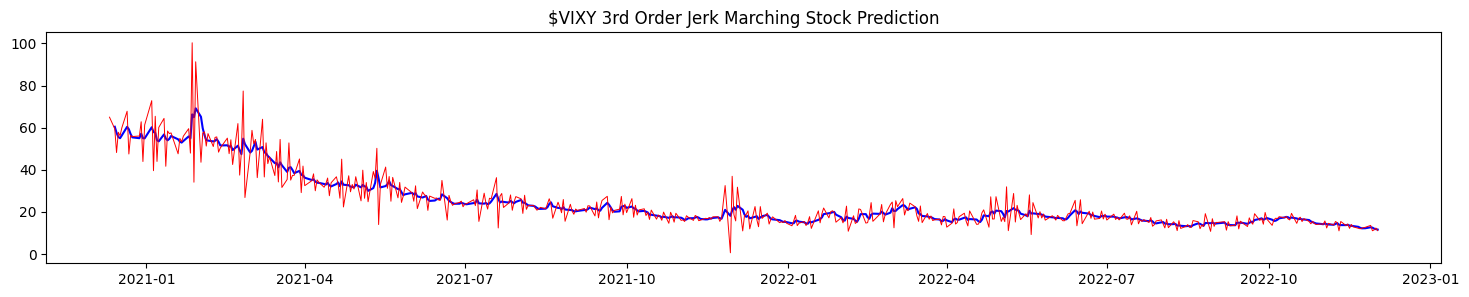

In [78]:
def jerk_predict(price_points):
    soln = []
    for step in range(3, prices.size):
        xi, xi_1, xi_2, xi_3 = price_points[step], price_points[step-1], price_points[step-2], price_points[step-3]
        # our price at a certain point... is just the price at a certain point (😁)
        p_x = xi
        # 4 point backward first derivative finite difference
        # difficulty finding this one... using a 3 point one for now as bandaid
        v_x = (3 * xi - 4 * xi_1 + xi_2) / 2
        # 4 point backward second derivative finite difference 
        a_x = (2 * xi) - (5 * xi_1) + (4 * xi_2) - (xi_3)
        # 4 point backward third derivative finite difference
        j_x = xi - (3 * xi_1) + (3 * xi_2) - (1 * xi_3)

        step_vec = np.array([p_x, v_x, a_x, j_x])
        soln.append(step_vec)
    return soln

def next_jerk_price(row):
    return row[0] + row[1] + (1/2)*row[2] + (1/6)*row[3]

jerk_points = jerk_predict(prices)
day = 3
one_step_guesses = []

for row in jerk_points:
    guess = np.round(next_jerk_price(row), 3)
    one_step_guesses.append(guess)
    day += 1

    #print("(Actual) Day",day,row[0])
    #print("(Prediction) Day",day+1,guess)

#print(np.array([x - y for x, y in zip(one_step_guesses, price_compare)]))
price_compare = prices[4:] # predictions start on day 2 going to day 3 :)
#print(price_compare[:10],one_step_guesses[:10])
plt.plot(timestamps[4:], price_compare, color="blue", label="actual")
plt.plot(timestamps[3:], one_step_guesses, color="red", label="predicted", linewidth=0.7)
plt.title(f"${ticker} 3rd Order Jerk Marching Stock Prediction")
diffs = np.array([abs(x - y) for x, y in zip(one_step_guesses, price_compare)])
print("Average difference in prediction and actual value:",np.average(diffs))

mse = np.square(np.subtract(price_compare, one_step_guesses[:len(one_step_guesses)-1])).mean()
print("MSE:",mse)

# Snap, and Some Thoughts

Okay... we got worse results when including jerk in a marching solution... what happens if we add in *snap*?

Where snap is the 4th derivative: 

$s = \frac{d^4x}{dt^4} = \frac{d^3v}{dt^3} = \frac{d^2a}{dt^2} = \frac{dj}{dt}$

Then in our model, a discretized form of te 4th derivative:

$p^{iv}(t) = \frac{p(t) - 4p(t-1) + 6p(t-2) - 4p(t-3) + p(t-4)}{h^4}$

Of course, to be proper, this means that we should be changing all of our backwards differences formulas to each have 5 points... but not quite sure how to formulate that. Transforming to code:

Average difference in prediction and actual value: 3.2791653225806447
MSE: 27.67348112298387


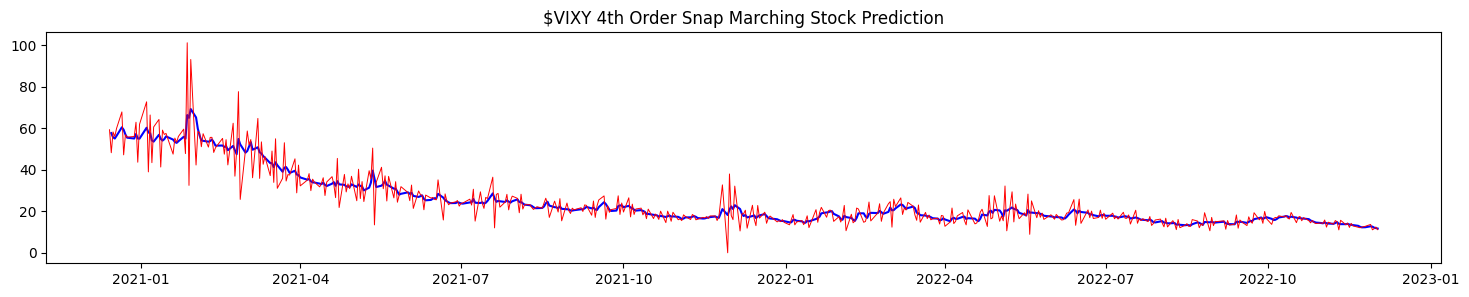

In [79]:
def snap_predict(price_points):
    soln = []
    for step in range(4, prices.size):
        xi, xi_1, xi_2, xi_3, xi_4 = price_points[step], price_points[step-1], price_points[step-2], price_points[step-3], price_points[step-4]
        # our price at a certain point... is just the price at a certain point (😁)
        p_x = xi
        # 4 point backward first derivative finite difference
        # difficulty finding this one... using a 3 point one for now as bandaid
        v_x = (3 * xi - 4 * xi_1 + xi_2) / 2
        # 4 point backward second derivative finite difference 
        a_x = (2 * xi) - (5 * xi_1) + (4 * xi_2) - (xi_3)
        # 4 point backward third derivative finite difference
        j_x = xi - (3 * xi_1) + (3 * xi_2) - (1 * xi_3)
        # 5 point backward fourth derivative finite different
        s_x = xi - 4 * xi_1 + 6 * xi_2 - 4 * xi_3 + xi_4

        step_vec = np.array([p_x, v_x, a_x, j_x, s_x])
        soln.append(step_vec)
    return soln

def next_snap_price(row):
    return row[0] + row[1] + (1/2)*row[2] + (1/6)*row[3] + (1/24)*row[4]

snap_points = snap_predict(prices)
day = 4
one_step_guesses = []

for row in snap_points:
    guess = np.round(next_snap_price(row), 3)
    one_step_guesses.append(guess)
    day += 1

    #print("(Actual) Day",day,row[0])
    #print("(Prediction) Day",day+1,guess)

price_compare = prices[5:] # predictions start on day 2 going to day 3 :)

plt.plot(timestamps[5:], price_compare, color="blue", label="actual")
plt.plot(timestamps[4:], one_step_guesses, color="red", label="predicted", linewidth=0.7)
plt.title(f"${ticker} 4th Order Snap Marching Stock Prediction")
# hacky compare results and actual
diffs = np.array([abs(x - y) for x, y in zip(one_step_guesses, price_compare)])
print("Average difference in prediction and actual value:",np.average(diffs))

mse = np.square(np.subtract(price_compare, one_step_guesses[1:])).mean()
print("MSE:",mse)

# Unfortunate Results

We seem to be getting worse predictions every time we add a derivative. However, this is only ever marching 1 step out. With some refactoring, can we look at what these stocks do when they are being predicted more than a day out?

This is relatively easy to do, instead of iterating through and constructing a matrix of points for $[p(t_i), p'(t_i), p''(t_i), p'''(t_i), p''''(t_i)]$ from the correct price data, we just give it a few points, and let it step forward on its own prediction for a certain number of days $n$, then compare that to the actual results again.

Text(0.5, 1.0, '$VIXY Price Forecasting in 14 day blocks')

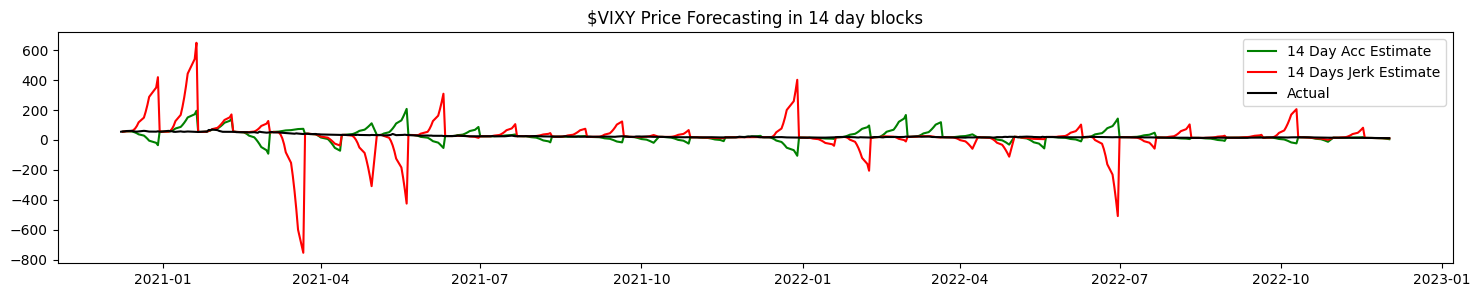

In [80]:
def nextaccel(start_points):
    xi, xi_1, xi_2 = start_points[2], start_points[1], start_points[0]
    
    p_x = xi
    # 3 point backwards first derivative finite difference
    v_x = (3 * xi - 4 * xi_1 + xi_2) / 2
    # 4 point backward second derivative finite difference 
    a_x = (xi) - (2 * xi_1) + (xi_2)
    
    return next_accel_price([p_x, v_x, a_x])


def nextjerk(start_points):
    xi, xi_1, xi_2, xi_3 = start_points[3], start_points[2], start_points[1], start_points[0]
    # our price at a certain point... is just the price at a certain point (😁)
    p_x = xi
    # 4 point backward first derivative finite difference
    # difficulty finding this one... using a 3 point one for now as bandaid
    v_x = (3 * xi - 4 * xi_1 + xi_2) / 2
    # 4 point backward second derivative finite difference 
    a_x = (2 * xi) - (5 * xi_1) + (4 * xi_2) - (xi_3)
    # 4 point backward third derivative finite difference
    j_x = xi - (3 * xi_1) + (3 * xi_2) - (1 * xi_3)

    return next_jerk_price([p_x, v_x, a_x, j_x])

#def nextsnap(start_points):
    
further_predict_acc = []
further_predict_jerk = []
n = 14 # num of days to self-predict

for day in range( 500):
    if day % n == 0 or day % n == 1 or day % n == 2:
        further_predict_acc.append(prices[day])
        further_predict_jerk.append(prices[day])
    else:
        further_predict_acc.append(nextaccel(further_predict_acc[day-3:]))
        if day % n == 3:
            further_predict_jerk.append(prices[day])
        else:
            further_predict_jerk.append(nextjerk(further_predict_jerk[day-4:]))

#print(every_n_reset)
plt.plot(timestamps[1:], further_predict_acc, color="green", label=f"{n} Day Acc Estimate")
plt.plot(timestamps[1:], further_predict_jerk, color = "red", label=f"{n} Days Jerk Estimate")

plt.plot(timestamps, prices, color = "black", label="Actual")
plt.legend()
plt.title(f"${ticker} Price Forecasting in {n} day blocks")

# A Theoretical Trading Bot's Profitability

What if a bot were to be trading based off of our predicted prices?
Since our main algorithms only predict one day in advance, the general thought process of the trading bot would be the following:

Start with \$10000, on day 0. Current price is $P_0$.

If $P_i+1 > P_i$ (our predicted stock price is *higher* than current price), we buy as much stock as we can, turning $\frac{\$10,000}{Price Per Share} = NumShares$

If $P_i+1 < P_i$ (our predicted stock price is *lower* than current price), we sell as much stock as we can, turning number of shares into cash.

At each time step, calculate total assets by adding cash + numShares*currPrice

Text(0.5, 1.0, 'Bot Results on Extremely Aggressive $VIXY Trading')

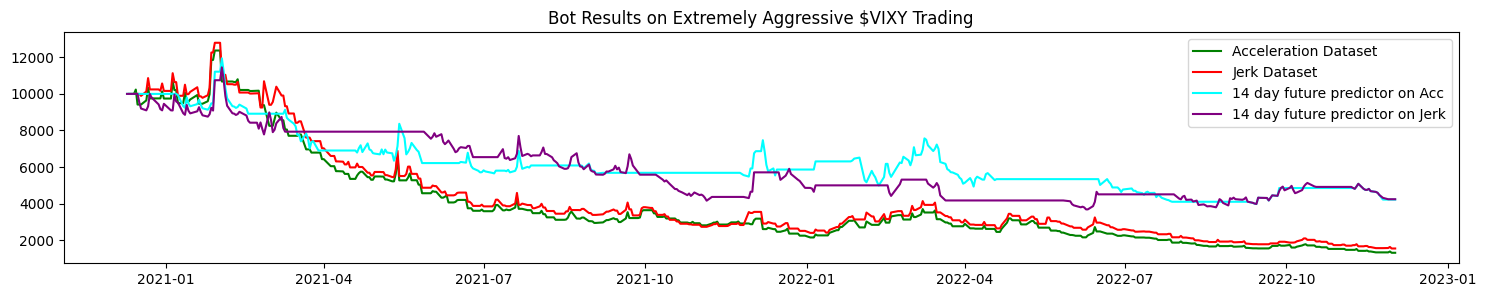

In [82]:
def bot(actual, predicted):
    stocks_owned = 0
    cash = 10_000
    total_assets = [cash]
    for day in range(1, len(predicted) - 1):
        if day >= len(predicted) - 1 or predicted[day] < actual[day - 1]:
            cash += actual[day]*stocks_owned
            stocks_owned = 0
        
        if predicted[day] > actual[day - 1]:
            stocks_owned += cash/actual[day - 1]
            cash = 0

        total_assets.append(cash + stocks_owned*actual[day - 1])
    return total_assets

one_step_acc_guesses = []
for row in accel_predict(prices):
    #print("(Actual) Day",day,row[0])
    guess = np.round(next_accel_price(row), 3)
    #print("(Prediction) Day",day+1,guess)
    one_step_acc_guesses.append(guess)
    day += 1

jerk_points = jerk_predict(prices)

one_step_jerk_guesses = []
for row in jerk_points:
    guess = np.round(next_jerk_price(row), 3)
    one_step_jerk_guesses.append(guess)


total_acc_moneys = bot(prices[3:], one_step_acc_guesses)
total_jerk_moneys = bot(prices[4:], one_step_jerk_guesses)
acc_future = bot(prices[1:], further_predict_acc)
jerk_future = bot(prices[1:], further_predict_jerk)

#print(total_acc_moneys)
plt.plot(timestamps[3:], total_acc_moneys, color="green", label="Acceleration Dataset")
plt.plot(timestamps[4:], total_jerk_moneys, color="red", label="Jerk Dataset")
plt.plot(timestamps[2:], acc_future, color="cyan", label=f"{n} day future predictor on Acc")
plt.plot(timestamps[2:], jerk_future, color="purple", label=f"{n} day future predictor on Jerk")
plt.legend()
plt.title(f"Bot Results on Extremely Aggressive ${ticker} Trading")

#plt.plot(timestamps, prices, color = "gray", label="Actual Stock Price")